# SVR

We will apply following approach in case of SVR:
 * we will perform feature engineering - standardization
 * then we will find "good enough" parameters (in CV) to proceed feature selection procedure and after that we will have groups of feature candidates
 * then we will tune hyperparameters for each group of variables (in CV) - we will obtain couple of models
 * then we will compare all models based on so called "proper CV" and we will fit and picke the winner!

We are aware of potential data leakage in case of usage KFold CV without time-series problem handling (in point 2 and 3). 

*To be honest in this problem it is not a big deal - based on our experience and we treat it like a feature!*

During the last step of our procedure we will verify previous analysis based on "proper CV" which handle time-series properties!!! So during hyperparameters tuning we will use different CV (we fight against data leakage).

### Dependencies loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pickle

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 150)

# np.random.seed(1916) #uncomment if you want your code to be reproducible; for the purposes of our activity, let's add some randomness to the results

### Data loading

In [3]:
preprocessed_output_data_path = "../data/output"

df = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv", index_col=0)

fr = pd.read_excel(f"{preprocessed_output_data_path}/feature_ranking.xlsx", index_col=0)

### Feature engineering for SVR model

We have to standardize our variables. We will use z-score standardization!

In [4]:
print(df.columns.tolist())

['Ticker', 'Nazwa2', 'rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_c

In [5]:
columns = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "etr",
    "diff",
    "roa",
    "lev",
    "intan",
    "rd",
    "ppe",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "ta_log",
    "txt_cat_(-63.011, -34.811]",
    "txt_cat_(-34.811, 0.488]",
    "txt_cat_(0.488, 24.415]",
    "txt_cat_(24.415, 25.05]",
    "txt_cat_(25.05, 308.55]",
    "txt_cat_(308.55, 327.531]",
    "txt_cat_(327.531, inf]",
    "pi_cat_(-8975.0, -1.523]",
    "pi_cat_(-1.523, 157.119]",
    "pi_cat_(157.119, 465.9]",
    "pi_cat_(465.9, 7875.5]",
    "pi_cat_(7875.5, 8108.5]",
    "pi_cat_(8108.5, inf]",
    "str_cat_(0.0875, 0.192]",
    "str_cat_(0.192, 0.28]",
    "str_cat_(0.28, inf]",
    "xrd_exists",
    "ni_profit",
    "ni_profit_20000",
    "ppent_sqrt",
    "intant_sqrt",
    "dlc_cat_(42.262, 176.129]",
    "dlc_cat_(176.129, 200.9]",
    "dlc_cat_(200.9, inf]",
    "dltt_cat_(39.38, 327.85]",
    "dltt_cat_(327.85, 876.617]",
    "dltt_cat_(876.617, inf]",
    "capex_cat_(7.447, 79.55]",
    "capex_cat_(79.55, 5451.0]",
    "capex_cat_(5451.0, inf]",
    "revenue_cat_(0.174, 1248.817]",
    "revenue_cat_(1248.817, 4233.587]",
    "revenue_cat_(4233.587, inf]",
    "cce_cat_(5.619, 63.321]",
    "cce_cat_(63.321, inf]",
    "adv_cat_(0.3, 874.5]",
    "adv_cat_(874.5, inf]",
    "diff_positive",
    "roa_clip",
    "lev_sqrt",
    "intan_pow2",
    "rd_sqrt",
    "ppe_clip",
    "cash_holdings_sqrt",
    "adv_expenditure_positive",
    "diff_dta",
    "cfc_dta",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]

In [6]:
standardization = list()
not_standardization = list()
for i in columns:
    if df[i].nunique() > 2:
        standardization.append(i)
    else:
        not_standardization.append(i)

In [7]:
print(standardization)

['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'capex2_scaled', 'y_v2x_polyarchy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'ta_log', 'ppent_sqrt', 'intant_sqrt', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 'cash_holdings_sqrt', 'diff_dta', 'etr_y_past', 'etr_y_ma', 'diff_ma', 'roa_ma', 'lev_ma', 'intan_ma', 'ppe_ma', 'sale_ma', 'cash_holdings_ma', 'roa_past', 'lev_past', 'intan_past', 'ppe_past', 'sale_past', 'cash_holdings_past']


In [8]:
print(not_standardization)

['cfc', 'dta', 'y_e_p_polity', 'y_BR_Democracy', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28]', 'str_cat_(0.28, inf]', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'dlc_cat_(42.262, 176.129]', 'dlc_cat_(176.129, 200.9]', 'dlc_cat_(200.9, inf]', 'dltt_cat_(39.38, 327.85]', 'dltt_cat_(327.85, 876.617]', 'dltt_cat_(876.617, inf]', 'capex_cat_(7.447, 79.55]', 'capex_cat_(79.55, 5451.0]', '

In [9]:
standardization.remove("etr")

In [10]:
standardization.append("y_e_p_polity")

In [11]:
print(standardization)

['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'capex2_scaled', 'y_v2x_polyarchy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'ta_log', 'ppent_sqrt', 'intant_sqrt', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 'cash_holdings_sqrt', 'diff_dta', 'etr_y_past', 'etr_y_ma', 'diff_ma', 'roa_ma', 'lev_ma', 'intan_ma', 'ppe_ma', 'sale_ma', 'cash_holdings_ma', 'roa_past', 'lev_past', 'intan_past', 'ppe_past', 'sale_past', 'cash_holdings_past', 'y_e_p_polity']


In [12]:
# df[standardization]= df[standardization].apply(lambda x: (x-x.mean())/x.std())

In [13]:
scaler = StandardScaler()
scaler.fit(df[standardization])
df[standardization] = scaler.transform(df[standardization])

In [14]:
pickle.dump(scaler, open("../models/standardscaler.sav", "wb"))

### Searching for "good enough" model to feature selection

In [15]:
var = fr.mi_score.sort_values(ascending=False).index.tolist()[0:10]

In [16]:
print(var)

['etr_y_past', 'etr_y_ma', 'txt', 'diff', 'ni', 'pi', 'intant', 'intant_sqrt', 'ta', 'revenue']


In [23]:
param = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [1, 2, 3],
    "C": [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10],
    "epsilon": [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10],
    "cache_size": [500],
}

In [24]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

Unfortunately above procedure will take too much time. We have to deal with it :(

In [25]:
param = {"kernel": ["linear", "poly", "rbf", "sigmoid"], "degree": [1, 2, 3]}
model = SVR()
grid_CV = GridSearchCV(
    model, param, cv=5, scoring=mse, return_train_score=True, n_jobs=-1
)
grid_CV.fit(df.loc[:, var].values, df.loc[:, "etr"].values.ravel())

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [1, 2, 3],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [26]:
grid_CV.best_params_

{'degree': 1, 'kernel': 'rbf'}

In [27]:
kf = KFold(n_splits=5)
rmse_l = list()
rmse_t_l = list()
model = SVR(
    kernel="linear",
    tol=0.001,
    C=1,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)

for train, test in kf.split(df.index.values):
    X = df.iloc[train].copy()
    model.fit(X[var].values, X["etr"].values)
    pred_y_train = model.predict(X[var].values)
    rmse_t = np.sqrt(mean_squared_error(df.iloc[train]["etr"].values, pred_y_train))
    rmse_t_l.append(rmse_t)

    pred_y_test = model.predict(df.iloc[test][var].values)
    rmse = np.sqrt(mean_squared_error(df.iloc[test]["etr"].values, pred_y_test))
    rmse_l.append(rmse)

#     print(rmse_t, rmse)

print(np.mean(rmse_t_l))
print(rmse_t_l)
print(np.mean(rmse_l))
print(rmse_l)

0.14327939515042282
[0.1465951278474606, 0.14593945569249792, 0.1439720733606676, 0.13824579432321327, 0.1416445245282746]
0.16254436037277387
[0.13563839215510284, 0.13672868331284194, 0.13975607376036572, 0.24837142597129938, 0.15222722666425947]


In [28]:
kf = KFold(n_splits=5)
rmse_l = list()
rmse_t_l = list()
model = SVR(
    kernel="rbf",
    tol=0.001,
    C=1,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)

for train, test in kf.split(df.index.values):
    X = df.iloc[train].copy()
    model.fit(X[var].values, X["etr"].values)
    pred_y_train = model.predict(X[var].values)
    rmse_t = np.sqrt(mean_squared_error(df.iloc[train]["etr"].values, pred_y_train))
    rmse_t_l.append(rmse_t)

    pred_y_test = model.predict(df.iloc[test][var].values)
    rmse = np.sqrt(mean_squared_error(df.iloc[test]["etr"].values, pred_y_test))
    rmse_l.append(rmse)

#     print(rmse_t, rmse)

print(np.mean(rmse_t_l))
print(rmse_t_l)
print(np.mean(rmse_l))
print(rmse_l)

0.13450210931547166
[0.13947007647404727, 0.13546250495394987, 0.13542510906082467, 0.12994542265852593, 0.1322074334300106]
0.14682436927907966
[0.13090333865620085, 0.14462122117596826, 0.14092458048748313, 0.1648006009490234, 0.15287210512672264]


In [29]:
kf = KFold(n_splits=5)
rmse_l = list()
rmse_t_l = list()
model = SVR(
    kernel="poly",
    tol=0.001,
    C=1,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)

for train, test in kf.split(df.index.values):
    X = df.iloc[train].copy()
    model.fit(X[var].values, X["etr"].values)
    pred_y_train = model.predict(X[var].values)
    rmse_t = np.sqrt(mean_squared_error(df.iloc[train]["etr"].values, pred_y_train))
    rmse_t_l.append(rmse_t)

    pred_y_test = model.predict(df.iloc[test][var].values)
    rmse = np.sqrt(mean_squared_error(df.iloc[test]["etr"].values, pred_y_test))
    rmse_l.append(rmse)

#     print(rmse_t, rmse)

print(np.mean(rmse_t_l))
print(rmse_t_l)
print(np.mean(rmse_l))
print(rmse_l)

0.14197135680059203
[0.14507426507011167, 0.14325868861032176, 0.14361416456786905, 0.13771763412791443, 0.14019203162674335]
1.8403272456124165
[1.0174547530600375, 0.23404708266234522, 0.1493213346086361, 7.609715186182617, 0.19109787154844532]


In [30]:
kf = KFold(n_splits=5)
rmse_l = list()
rmse_t_l = list()
model = SVR(
    kernel="poly",
    degree=3,
    tol=0.001,
    C=1,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)

for train, test in kf.split(df.index.values):
    X = df.iloc[train].copy()
    model.fit(X[var].values, X["etr"].values)
    pred_y_train = model.predict(X[var].values)
    rmse_t = np.sqrt(mean_squared_error(df.iloc[train]["etr"].values, pred_y_train))
    rmse_t_l.append(rmse_t)

    pred_y_test = model.predict(df.iloc[test][var].values)
    rmse = np.sqrt(mean_squared_error(df.iloc[test]["etr"].values, pred_y_test))
    rmse_l.append(rmse)

#     print(rmse_t, rmse)

print(np.mean(rmse_t_l))
print(rmse_t_l)
print(np.mean(rmse_l))
print(rmse_l)

0.14197135680059203
[0.14507426507011167, 0.14325868861032176, 0.14361416456786905, 0.13771763412791443, 0.14019203162674335]
1.8403272456124165
[1.0174547530600375, 0.23404708266234522, 0.1493213346086361, 7.609715186182617, 0.19109787154844532]


In [31]:
kf = KFold(n_splits=5)
rmse_l = list()
rmse_t_l = list()
model = SVR(
    kernel="sigmoid",
    tol=0.001,
    C=1,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)

for train, test in kf.split(df.index.values):
    X = df.iloc[train].copy()
    model.fit(X[var].values, X["etr"].values)
    pred_y_train = model.predict(X[var].values)
    rmse_t = np.sqrt(mean_squared_error(df.iloc[train]["etr"].values, pred_y_train))
    rmse_t_l.append(rmse_t)

    pred_y_test = model.predict(df.iloc[test][var].values)
    rmse = np.sqrt(mean_squared_error(df.iloc[test]["etr"].values, pred_y_test))
    rmse_l.append(rmse)

#     print(rmse_t, rmse)

print(np.mean(rmse_t_l))
print(rmse_t_l)
print(np.mean(rmse_l))
print(rmse_l)

43.84164120780724
[47.46607898392438, 41.49796576782989, 43.720809421618526, 42.39961145666728, 44.12374040899612]
39.680126970973056
[58.528276865807854, 38.58374060713013, 23.144138539791403, 47.20237258003376, 30.94210626210213]


We see that results from sklearn gridsearch and our own procedure of CV are the same!

Let's build such a intuition in case of parameters for C and epsilon.

In [36]:
for c in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10]:
    kf = KFold(n_splits=5)
    rmse_l = list()
    rmse_t_l = list()
    model = SVR(
        kernel="rbf",
        tol=0.001,
        C=c,
        epsilon=0.1,
        shrinking=True,
        cache_size=500,
        verbose=False,
        max_iter=-1,
    )

    for train, test in kf.split(df.index.values):
        X = df.iloc[train].copy()
        model.fit(X[var].values, X["etr"].values)
        pred_y_train = model.predict(X[var].values)
        rmse_t = np.sqrt(mean_squared_error(df.iloc[train]["etr"].values, pred_y_train))
        rmse_t_l.append(rmse_t)

        pred_y_test = model.predict(df.iloc[test][var].values)
        rmse = np.sqrt(mean_squared_error(df.iloc[test]["etr"].values, pred_y_test))
        rmse_l.append(rmse)

    #     print(rmse_t, rmse)
    print(c)
    print(np.mean(rmse_t_l))
    print(rmse_t_l)
    print(np.mean(rmse_l))
    print(rmse_l)
    print("\n")

0.01
0.1420033189967873
[0.145293778022781, 0.14383543036951082, 0.14278487770511328, 0.13852507847084267, 0.13957743041568868]
0.1429878844431951
[0.13168638607874633, 0.1366093517921841, 0.1373477660356689, 0.15787057604234836, 0.15142534226702792]


0.1
0.13998208263822012
[0.14355307251377133, 0.14168705080583865, 0.14066767576521225, 0.13624356909194044, 0.13775904501433792]
0.14398191086142326
[0.13274132659425242, 0.1378239522766735, 0.13845251837606667, 0.1592603170615792, 0.15163143999854456]


0.25
0.13826295514957493
[0.14224884776844818, 0.1396560826950291, 0.13896196887141965, 0.134272536981566, 0.13617533943141166]
0.14447967468127784
[0.13248515130688662, 0.13879892250381912, 0.13907360907962868, 0.16027515348582433, 0.15176553703023046]


0.5
0.1363467708369912
[0.14089449455853187, 0.13744378291845047, 0.13722823838733494, 0.131883344298254, 0.1342839940223848]
0.14536109473137232
[0.1322737697792047, 0.141076553322157, 0.13967433213484215, 0.1619781899941994, 0.151802

In [37]:
for e in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10]:
    kf = KFold(n_splits=5)
    rmse_l = list()
    rmse_t_l = list()
    model = SVR(
        kernel="rbf",
        tol=0.001,
        C=10,
        epsilon=e,
        shrinking=True,
        cache_size=500,
        verbose=False,
        max_iter=-1,
    )

    for train, test in kf.split(df.index.values):
        X = df.iloc[train].copy()
        model.fit(X[var].values, X["etr"].values)
        pred_y_train = model.predict(X[var].values)
        rmse_t = np.sqrt(mean_squared_error(df.iloc[train]["etr"].values, pred_y_train))
        rmse_t_l.append(rmse_t)

        pred_y_test = model.predict(df.iloc[test][var].values)
        rmse = np.sqrt(mean_squared_error(df.iloc[test]["etr"].values, pred_y_test))
        rmse_l.append(rmse)

    #     print(rmse_t, rmse)
    print(e)
    print(np.mean(rmse_t_l))
    print(rmse_t_l)
    print(np.mean(rmse_l))
    print(rmse_l)
    print("\n")

0.01
0.14138007348381199
[0.14497663815281236, 0.14340239846947173, 0.1424327891241189, 0.13722549863156794, 0.13886304304108898]
0.14228204383870285
[0.1300138298751914, 0.13611868697899196, 0.13813266388380094, 0.15685583842798753, 0.15028920002754242]


0.1
0.1420033189967873
[0.145293778022781, 0.14383543036951082, 0.14278487770511328, 0.13852507847084267, 0.13957743041568868]
0.1429878844431951
[0.13168638607874633, 0.1366093517921841, 0.1373477660356689, 0.15787057604234836, 0.15142534226702792]


0.25
0.15683266303507887
[0.1589188696222363, 0.15921884243149123, 0.15776659754986283, 0.15393946598545113, 0.15431953958635286]
0.15696371275170629
[0.14882381782454704, 0.14767486987736939, 0.15155902691936207, 0.1678594516701592, 0.16890139746709365]


0.5
0.32388509719541736
[0.32520531078076087, 0.3270158248991175, 0.321673546723654, 0.3229354409860673, 0.32259536258748694]
0.3237976943652259
[0.31858199098417506, 0.311085227092855, 0.33260676521270166, 0.32768804201378193, 0.3290

Our quasi final model for this procedure:

In [39]:
model = SVR(
    kernel="rbf",
    C=10,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)

### Feature selection for SVR

We would like to base our feature selection on:
 * feature ranking
 * forward elimination
 * recursive feature elimination - using "linear" kernel

#### Feature ranking

In [40]:
fr.sort_values("mi_score", ascending=False, inplace=True)

In [41]:
fr.head()

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
etr_y_past,1.009402,1.304040e-84,1,0.520405,NaN,1
etr_y_ma,0.825650,2.473770e-125,1,0.526871,NaN,1
txt,0.633067,5.246456e-13,1,0.368732,1.466269e-05,1
diff,0.632640,2.257712e-02,1,-0.291716,NaN,1
ni,0.613297,1.747230e-09,1,0.263458,-3.442000e-07,7


In [42]:
br_features = fr[fr.boruta_rank.isin([1, 2, 3])].index.tolist()

In [43]:
mi_features = fr.iloc[0:20].index.tolist()

In [44]:
mi_features_25 = fr.iloc[0:25].index.tolist()

In [45]:
mi_features_35 = fr.iloc[0:35].index.tolist()

In [46]:
mi_features_50 = fr.iloc[0:50].index.tolist()

In [47]:
fr["corr_abs"] = np.abs(fr["corr"])
fr.sort_values("corr_abs", ascending=False, inplace=True)
corr_features = fr.iloc[0:20].index.tolist()

We will use our intuition and create two additional benchmark sets of variables:

In [48]:
benchmark = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "roa",
    "lev",
    "intan",
    "rd",
    "ppe",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]

In [49]:
benchmark2 = [
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "roa",
    "lev",
    "intan",
    "rd",
    "ppe",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "y_v2x_polyarchy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]

#### Forward elimination

In [50]:
forward_elimination = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "roa",
    "lev",
    "intan",
    "rd",
    "ppe",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "ta_log",
    "txt_cat_(-63.011, -34.811]",
    "txt_cat_(-34.811, 0.488]",
    "txt_cat_(0.488, 24.415]",
    "txt_cat_(24.415, 25.05]",
    "txt_cat_(25.05, 308.55]",
    "txt_cat_(308.55, 327.531]",
    "txt_cat_(327.531, inf]",
    "pi_cat_(-8975.0, -1.523]",
    "pi_cat_(-1.523, 157.119]",
    "pi_cat_(157.119, 465.9]",
    "pi_cat_(465.9, 7875.5]",
    "pi_cat_(7875.5, 8108.5]",
    "pi_cat_(8108.5, inf]",
    "str_cat_(0.0875, 0.192]",
    "str_cat_(0.192, 0.28]",
    "str_cat_(0.28, inf]",
    "xrd_exists",
    "ni_profit",
    "ni_profit_20000",
    "ppent_sqrt",
    "intant_sqrt",
    "dlc_cat_(42.262, 176.129]",
    "dlc_cat_(176.129, 200.9]",
    "dlc_cat_(200.9, inf]",
    "dltt_cat_(39.38, 327.85]",
    "dltt_cat_(327.85, 876.617]",
    "dltt_cat_(876.617, inf]",
    "capex_cat_(7.447, 79.55]",
    "capex_cat_(79.55, 5451.0]",
    "capex_cat_(5451.0, inf]",
    "revenue_cat_(0.174, 1248.817]",
    "revenue_cat_(1248.817, 4233.587]",
    "revenue_cat_(4233.587, inf]",
    "cce_cat_(5.619, 63.321]",
    "cce_cat_(63.321, inf]",
    "adv_cat_(0.3, 874.5]",
    "adv_cat_(874.5, inf]",
    "diff_positive",
    "roa_clip",
    "lev_sqrt",
    "intan_pow2",
    "rd_sqrt",
    "ppe_clip",
    "cash_holdings_sqrt",
    "adv_expenditure_positive",
    "diff_dta",
    "cfc_dta",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]
forward_elimination.remove("ta_log")
forward_elimination.remove("ppent_sqrt")
forward_elimination.remove("intant_sqrt")
forward_elimination.remove("roa")
forward_elimination.remove("lev")
forward_elimination.remove("intan")
forward_elimination.remove("rd_sqrt")
forward_elimination.remove("ppe")
forward_elimination.remove("cash_holdings_sqrt")

In [51]:
candidates_withoud_discr = [i for i in forward_elimination if "]" not in i]

In [52]:
model = SVR(
    kernel="rbf",
    C=10,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)

In [53]:
sf = SFS(
    model,
    k_features=(5, 20),
    forward=True,
    floating=False,
    verbose=0,
    scoring=mse,
    cv=5,
    n_jobs=-1,
)

sffit = sf.fit(
    df.loc[:, candidates_withoud_discr].values, df.loc[:, "etr"].values.ravel()
)

sf_features = df.loc[:, candidates_withoud_discr].columns[list(sffit.k_feature_idx_)]

sf_features

Index(['rok', 'cfc', 'y_e_p_polity', 'y_BR_Democracy', 'etr_y_ma'], dtype='object')

In [54]:
model = SVR(
    kernel="rbf",
    C=10,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)

In [55]:
sf = SFS(
    model,
    k_features=(5, 20),
    forward=True,
    floating=False,
    verbose=0,
    scoring=mse,
    cv=5,
    n_jobs=-1,
)

sffit = sf.fit(df.loc[:, forward_elimination].values, df.loc[:, "etr"].values.ravel())

sf_features2 = df.loc[:, forward_elimination].columns[list(sffit.k_feature_idx_)]

sf_features2

Index(['rok', 'ni', 'cfc', 'y_BR_Democracy', 'txt_cat_(24.415, 25.05]',
       'pi_cat_(7875.5, 8108.5]', 'dlc_cat_(42.262, 176.129]', 'etr_y_ma'],
      dtype='object')

Ten hours later!

#### Recursive Feature Elimination 

In [56]:
rfe_candidates = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "roa",
    "lev",
    "intan",
    "rd",
    "ppe",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "ta_log",
    "txt_cat_(-63.011, -34.811]",
    "txt_cat_(-34.811, 0.488]",
    "txt_cat_(0.488, 24.415]",
    "txt_cat_(24.415, 25.05]",
    "txt_cat_(25.05, 308.55]",
    "txt_cat_(308.55, 327.531]",
    "txt_cat_(327.531, inf]",
    "pi_cat_(-8975.0, -1.523]",
    "pi_cat_(-1.523, 157.119]",
    "pi_cat_(157.119, 465.9]",
    "pi_cat_(465.9, 7875.5]",
    "pi_cat_(7875.5, 8108.5]",
    "pi_cat_(8108.5, inf]",
    "str_cat_(0.0875, 0.192]",
    "str_cat_(0.192, 0.28]",
    "str_cat_(0.28, inf]",
    "xrd_exists",
    "ni_profit",
    "ni_profit_20000",
    "ppent_sqrt",
    "intant_sqrt",
    "dlc_cat_(42.262, 176.129]",
    "dlc_cat_(176.129, 200.9]",
    "dlc_cat_(200.9, inf]",
    "dltt_cat_(39.38, 327.85]",
    "dltt_cat_(327.85, 876.617]",
    "dltt_cat_(876.617, inf]",
    "capex_cat_(7.447, 79.55]",
    "capex_cat_(79.55, 5451.0]",
    "capex_cat_(5451.0, inf]",
    "revenue_cat_(0.174, 1248.817]",
    "revenue_cat_(1248.817, 4233.587]",
    "revenue_cat_(4233.587, inf]",
    "cce_cat_(5.619, 63.321]",
    "cce_cat_(63.321, inf]",
    "adv_cat_(0.3, 874.5]",
    "adv_cat_(874.5, inf]",
    "diff_positive",
    "roa_clip",
    "lev_sqrt",
    "intan_pow2",
    "rd_sqrt",
    "ppe_clip",
    "cash_holdings_sqrt",
    "adv_expenditure_positive",
    "diff_dta",
    "cfc_dta",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]
rfe_candidates.remove("ta_log")
rfe_candidates.remove("ppent_sqrt")
rfe_candidates.remove("intant_sqrt")
rfe_candidates.remove("roa")
rfe_candidates.remove("lev")
rfe_candidates.remove("intan")
rfe_candidates.remove("rd_sqrt")
rfe_candidates.remove("ppe")
rfe_candidates.remove("cash_holdings_sqrt")

In [57]:
rfe_candidates_without_disc = [i for i in rfe_candidates if "]" not in i]

In [58]:
estimator = SVR(
    kernel="linear",
    C=10,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=7, n_jobs=-1)
selector = selector.fit(
    df.loc[:, rfe_candidates_without_disc].values, df.loc[:, "etr"].values.ravel()
)

In [59]:
df.loc[:, rfe_candidates_without_disc].iloc[:, selector.support_].columns.tolist()

['ta',
 'pi',
 'str',
 'xrd',
 'dlc',
 'capex',
 'revenue',
 'cce',
 'diff',
 'sale',
 'cash_holdings',
 'capex2',
 'cfc',
 'capex2_scaled',
 'WB_GDPpc',
 'rr_per_country',
 'rr_per_sector',
 'sektor_consumer discretionary',
 'sektor_consumer staples',
 'sektor_energy',
 'sektor_health care',
 'sektor_industrials',
 'sektor_materials',
 'sektor_real estate',
 'gielda_2',
 'gielda_3',
 'xrd_exists',
 'ni_profit',
 'ni_profit_20000',
 'diff_positive',
 'lev_sqrt',
 'etr_y_ma',
 'lev_ma',
 'lev_past',
 'sale_past',
 'cash_holdings_past']

In [60]:
rfe_candidates_without_disc = (
    df.loc[:, rfe_candidates_without_disc].iloc[:, selector.support_].columns.tolist()
)

In [61]:
estimator = SVR(
    kernel="linear",
    C=10,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=7, n_jobs=-1)
selector = selector.fit(
    df.loc[:, rfe_candidates].values, df.loc[:, "etr"].values.ravel()
)

In [62]:
df.loc[:, rfe_candidates].iloc[:, selector.support_].columns.tolist()

['txt_cat_(-63.011, -34.811]',
 'txt_cat_(24.415, 25.05]',
 'txt_cat_(308.55, 327.531]',
 'pi_cat_(-8975.0, -1.523]',
 'pi_cat_(-1.523, 157.119]',
 'pi_cat_(157.119, 465.9]',
 'pi_cat_(465.9, 7875.5]',
 'pi_cat_(7875.5, 8108.5]',
 'pi_cat_(8108.5, inf]',
 'dlc_cat_(176.129, 200.9]']

In [63]:
rfe_candidates = df.loc[:, rfe_candidates].iloc[:, selector.support_].columns.tolist()

#### Permutation importance

Let's try something new for us - permutation importance for feature selection.

In [64]:
pi_candidates = [
    "rok",
    "ta",
    "txt",
    "pi",
    "str",
    "xrd",
    "ni",
    "ppent",
    "intant",
    "dlc",
    "dltt",
    "capex",
    "revenue",
    "cce",
    "adv",
    "diff",
    "rd",
    "sale",
    "cash_holdings",
    "adv_expenditure",
    "capex2",
    "cfc",
    "dta",
    "capex2_scaled",
    "y_v2x_polyarchy",
    "y_e_p_polity",
    "y_BR_Democracy",
    "WB_GDPgrowth",
    "WB_GDPpc",
    "WB_Inflation",
    "rr_per_country",
    "rr_per_sector",
    "sektor_consumer discretionary",
    "sektor_consumer staples",
    "sektor_energy",
    "sektor_health care",
    "sektor_industrials",
    "sektor_materials",
    "sektor_real estate",
    "sektor_technology",
    "sektor_utilities",
    "gielda_2",
    "gielda_3",
    "gielda_4",
    "gielda_5",
    "txt_cat_(-63.011, -34.811]",
    "txt_cat_(-34.811, 0.488]",
    "txt_cat_(0.488, 24.415]",
    "txt_cat_(24.415, 25.05]",
    "txt_cat_(25.05, 308.55]",
    "txt_cat_(308.55, 327.531]",
    "txt_cat_(327.531, inf]",
    "pi_cat_(-8975.0, -1.523]",
    "pi_cat_(-1.523, 157.119]",
    "pi_cat_(157.119, 465.9]",
    "pi_cat_(465.9, 7875.5]",
    "pi_cat_(7875.5, 8108.5]",
    "pi_cat_(8108.5, inf]",
    "str_cat_(0.0875, 0.192]",
    "str_cat_(0.192, 0.28]",
    "str_cat_(0.28, inf]",
    "xrd_exists",
    "ni_profit",
    "ni_profit_20000",
    "dlc_cat_(42.262, 176.129]",
    "dlc_cat_(176.129, 200.9]",
    "dlc_cat_(200.9, inf]",
    "dltt_cat_(39.38, 327.85]",
    "dltt_cat_(327.85, 876.617]",
    "dltt_cat_(876.617, inf]",
    "capex_cat_(7.447, 79.55]",
    "capex_cat_(79.55, 5451.0]",
    "capex_cat_(5451.0, inf]",
    "revenue_cat_(0.174, 1248.817]",
    "revenue_cat_(1248.817, 4233.587]",
    "revenue_cat_(4233.587, inf]",
    "cce_cat_(5.619, 63.321]",
    "cce_cat_(63.321, inf]",
    "adv_cat_(0.3, 874.5]",
    "adv_cat_(874.5, inf]",
    "diff_positive",
    "roa_clip",
    "lev_sqrt",
    "intan_pow2",
    "ppe_clip",
    "adv_expenditure_positive",
    "diff_dta",
    "cfc_dta",
    "etr_y_past",
    "etr_y_ma",
    "diff_ma",
    "roa_ma",
    "lev_ma",
    "intan_ma",
    "ppe_ma",
    "sale_ma",
    "cash_holdings_ma",
    "roa_past",
    "lev_past",
    "intan_past",
    "ppe_past",
    "sale_past",
    "cash_holdings_past",
]

In [65]:
estimator = SVR(
    kernel="rbf",
    C=10,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)
estimator.fit(df.loc[:, pi_candidates].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, pi_candidates].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
)
sorted_idx = result.importances_mean.argsort()

In [66]:
sorted_idx = sorted_idx[-20:]

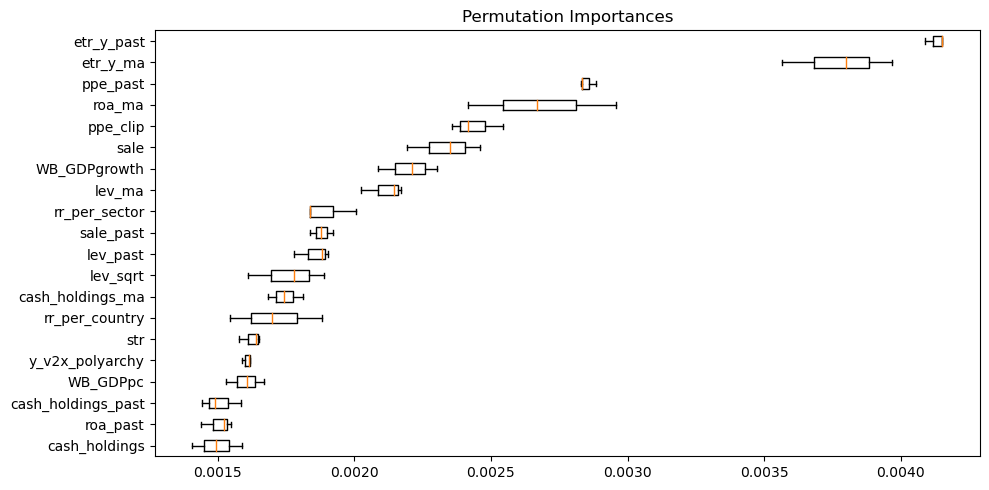

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, pi_candidates].columns[sorted_idx],
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [68]:
pi_var = df.loc[:, pi_candidates].columns[sorted_idx].tolist()

In [69]:
estimator = SVR(
    kernel="rbf",
    C=10,
    epsilon=0.1,
    shrinking=True,
    cache_size=500,
    verbose=False,
    max_iter=-1,
)
estimator.fit(df.loc[:, pi_var].values, df.loc[:, "etr"].values.ravel())
result = permutation_importance(
    estimator,
    df.loc[:, pi_var].values,
    df.loc[:, "etr"].values.ravel(),
    n_repeats=3,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
)
sorted_idx = result.importances_mean.argsort()

In [70]:
sorted_idx = sorted_idx[-10:]

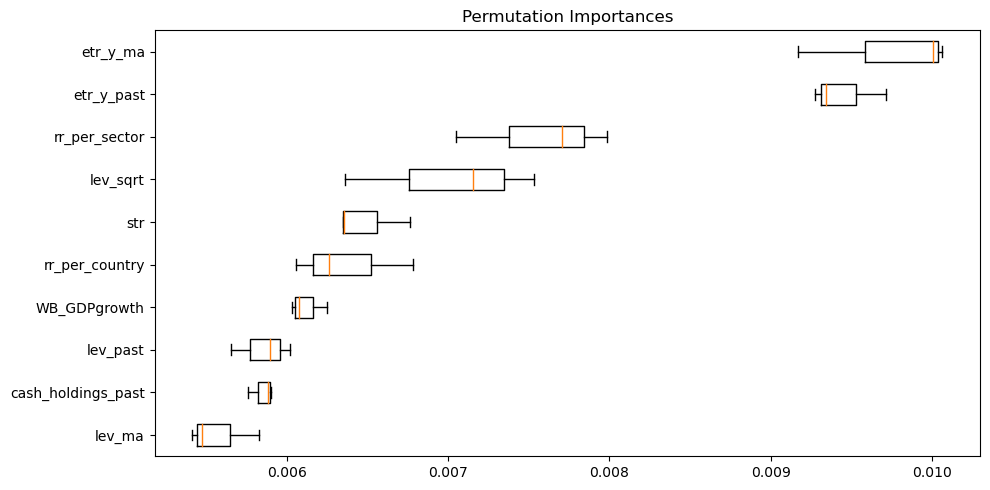

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=df.loc[:, pi_var].columns[sorted_idx],
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [72]:
pi_var_prim = df.loc[:, pi_var].columns[sorted_idx].tolist()

In [73]:
pi_var_prim

['lev_ma',
 'cash_holdings_past',
 'lev_past',
 'WB_GDPgrowth',
 'rr_per_country',
 'str',
 'lev_sqrt',
 'rr_per_sector',
 'etr_y_past',
 'etr_y_ma']

### Hyperparametes Tunning for each group of variables

In [74]:
param = {
    "C": [0.005, 0.01, 0.05, 0.1, 0.25],
    "epsilon": [0.005, 0.01, 0.05, 0.1],
    "kernel": ["rbf"],
}
mse = make_scorer(mean_squared_error, greater_is_better=True)

In [75]:
def cv_proc(var):
    model = SVR()
    grid_CV = GridSearchCV(
        model, param, cv=5, scoring=mse, return_train_score=True, n_jobs=-1
    )
    grid_CV.fit(df.loc[:, var].values, df.loc[:, "etr"].values.ravel())
    print(grid_CV.best_params_)
    print(grid_CV.best_score_)

In [76]:
cv_proc(br_features)

{'C': 0.25, 'epsilon': 0.005, 'kernel': 'rbf'}
0.020473027738694114


In [77]:
cv_proc(mi_features)

{'C': 0.25, 'epsilon': 0.1, 'kernel': 'rbf'}
0.021009431849439368


In [78]:
cv_proc(mi_features_25)

{'C': 0.25, 'epsilon': 0.1, 'kernel': 'rbf'}
0.021109140350410126


In [79]:
cv_proc(mi_features_35)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.02126626045928538


In [80]:
cv_proc(mi_features_50)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.021489628484500478


In [81]:
cv_proc(benchmark)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.0214738434688491


In [82]:
cv_proc(benchmark2)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.02138667661204189


In [83]:
cv_proc(sf_features)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.020714897148804857


In [84]:
cv_proc(sf_features2)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.020581786841789768


In [85]:
cv_proc(rfe_candidates_without_disc)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.021218504095009062


In [86]:
cv_proc(rfe_candidates)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.023332747131811753


In [87]:
cv_proc(pi_var_prim)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.020787540939917047


In [88]:
cv_proc(pi_var)

{'C': 0.005, 'epsilon': 0.1, 'kernel': 'rbf'}
0.021174088401426622


### Final models comparison - winner obtaining

We would like to fight against data leakage in our CV, so we will treat it like a panel problem with a rolling window. We now based on our experience that this kind of approach is crucial to fight against overfitting.

Sliding window:
 * T: 2005 - 2008; V: 2009
 * T: 2005 - 2009; V: 2010
 * T: 2005 - 2010; V: 2011
 * ...

In [91]:
df = df.sort_values(by="rok").reset_index(drop=True)

In [92]:
def proper_CV(x, y, model, display_res=False):
    train_score = list()
    valid_score = list()
    train_indexes = [0, 1452]
    valid_indexes = [1452, 1815]
    for i in range(0, 6):
        train_x = x[x.index.isin(range(train_indexes[0], train_indexes[1]))]
        train_y = y[y.index.isin(range(train_indexes[0], train_indexes[1]))]
        valid_x = x[x.index.isin(range(valid_indexes[0], valid_indexes[1]))]
        valid_y = y[y.index.isin(range(valid_indexes[0], valid_indexes[1]))]

        model.fit(train_x.values, train_y.values.ravel())

        pred_y_train = model.predict(train_x.values)
        rmse = np.sqrt(mean_squared_error(train_y, pred_y_train))
        train_score.append(rmse)

        pred_y_val = model.predict(valid_x.values)
        rmse = np.sqrt(mean_squared_error(valid_y, pred_y_val))
        valid_score.append(rmse)

        train_indexes = [0, valid_indexes[1]]
        valid_indexes = [train_indexes[1], valid_indexes[1] + 363]

    if display_res == True:
        view = pd.DataFrame([train_score, valid_score]).T.rename(
            columns={0: "cv_train", 1: "cv_val"}
        )
        display(view)
        return train_score, valid_score, view
    else:
        return train_score, valid_score

In [93]:
hp = [
    {"C": 0.25, "epsilon": 0.005, "kernel": "rbf"},
    {"C": 0.25, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.25, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
    {"C": 0.005, "epsilon": 0.1, "kernel": "rbf"},
]

In [107]:
model = SVR(**hp[0])
var = br_features
cv_output0 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.134222,0.149424
1,0.135224,0.134762
2,0.134153,0.150527
3,0.135747,0.148552
4,0.136399,0.127920
5,0.135766,0.134587


In [108]:
model = SVR(**hp[1])
var = mi_features
cv_output1 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.132702,0.141898
1,0.133465,0.136143
2,0.133042,0.149741
3,0.135693,0.147243
4,0.135711,0.129298
5,0.134502,0.135628


In [109]:
model = SVR(**hp[2])
var = mi_features_25
cv_output2 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.131936,0.141598
1,0.132671,0.136225
2,0.132384,0.149925
3,0.134587,0.147840
4,0.134904,0.129797
5,0.133872,0.136911


In [110]:
model = SVR(**hp[3])

var = mi_features_35
cv_output3 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.146095,0.134814
1,0.144374,0.135153
2,0.142954,0.148436
3,0.143574,0.147616
4,0.143316,0.131054
5,0.141933,0.136807


In [111]:
model = SVR(**hp[4])

var = mi_features_50
cv_output4 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.147681,0.133364
1,0.145315,0.135804
2,0.144007,0.148303
3,0.144418,0.147910
4,0.144198,0.131331
5,0.142771,0.137240


In [112]:
model = SVR(**hp[5])
var = benchmark
cv_output5 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.147263,0.132993
1,0.144791,0.136149
2,0.143448,0.149360
3,0.144028,0.148962
4,0.143927,0.132284
5,0.142478,0.136771


In [113]:
model = SVR(**hp[6])
var = benchmark2
cv_output6 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.147165,0.132973
1,0.144511,0.135948
2,0.143187,0.148616
3,0.143985,0.147984
4,0.143683,0.131501
5,0.142346,0.136195


In [114]:
model = SVR(**hp[7])

var = sf_features
cv_output7 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.140783,0.132922
1,0.139887,0.135021
2,0.139141,0.152122
3,0.140970,0.152111
4,0.141747,0.133731
5,0.140937,0.136954


In [115]:
model = SVR(**hp[8])

var = sf_features2
cv_output8 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.140517,0.133401
1,0.139471,0.134978
2,0.139117,0.152155
3,0.140745,0.151027
4,0.141371,0.132163
5,0.140421,0.135942


In [116]:
model = SVR(**hp[9])
var = rfe_candidates_without_disc
cv_output9 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.145696,0.133143
1,0.143528,0.136003
2,0.142491,0.147077
3,0.142933,0.147811
4,0.142688,0.131748
5,0.141533,0.135182


In [117]:
model = SVR(**hp[10])
var = rfe_candidates
cv_output10 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.156633,0.139362
1,0.153224,0.138238
2,0.151335,0.155645
3,0.152445,0.152620
4,0.152190,0.139453
5,0.151055,0.142193


In [118]:
model = SVR(**hp[11])

var = pi_var_prim
cv_output11 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.144135,0.133161
1,0.141644,0.133272
2,0.140641,0.149247
3,0.142016,0.148067
4,0.142477,0.129469
5,0.140979,0.133394


In [119]:
model = SVR(**hp[12])
var = pi_var
cv_output12 = proper_CV(df.loc[:, var], df.loc[:, "etr"], model, display_res=True)

,cv_train,cv_val
0,0.146127,0.132615
1,0.143648,0.134567
2,0.142416,0.149804
3,0.143464,0.146932
4,0.143372,0.130175
5,0.141909,0.134692


In [120]:
pd.DataFrame(
    [
        cv_output0[2].mean().tolist(),
        cv_output1[2].mean().tolist(),
        cv_output2[2].mean().tolist(),
        cv_output3[2].mean().tolist(),
        cv_output4[2].mean().tolist(),
        cv_output5[2].mean().tolist(),
        cv_output6[2].mean().tolist(),
        cv_output7[2].mean().tolist(),
        cv_output8[2].mean().tolist(),
        cv_output9[2].mean().tolist(),
        cv_output10[2].mean().tolist(),
        cv_output11[2].mean().tolist(),
        cv_output12[2].mean().tolist(),
    ],
    columns=["train_mean", "test_mean"],
)

,train_mean,test_mean
0,0.135252,0.140962
1,0.134186,0.139992
2,0.133392,0.140383
3,0.143707,0.138980
4,0.144732,0.138992
5,0.144323,0.139420
6,0.144146,0.138869
7,0.140577,0.140477
8,0.140274,0.139944
9,0.143145,0.138494


In [121]:
pd.DataFrame(
    [
        cv_output0[2].std().tolist(),
        cv_output1[2].std().tolist(),
        cv_output2[2].std().tolist(),
        cv_output3[2].std().tolist(),
        cv_output4[2].std().tolist(),
        cv_output5[2].std().tolist(),
        cv_output6[2].std().tolist(),
        cv_output7[2].std().tolist(),
        cv_output8[2].std().tolist(),
        cv_output9[2].std().tolist(),
        cv_output10[2].std().tolist(),
        cv_output11[2].std().tolist(),
        cv_output12[2].std().tolist(),
    ],
    columns=["train_std", "test_std"],
)

,train_std,test_std
0,0.000905,0.009694
1,0.001321,0.007739
2,0.001233,0.007610
3,0.001417,0.007260
4,0.001661,0.007346
5,0.001630,0.007743
6,0.001652,0.007521
7,0.000920,0.009118
8,0.000836,0.009121
9,0.001410,0.007096


8th models seems to be the best one! We see that our intuition was quite good - binary variables should be removed!

In [123]:
print(rfe_candidates_without_disc)

['ta', 'pi', 'str', 'xrd', 'dlc', 'capex', 'revenue', 'cce', 'diff', 'sale', 'cash_holdings', 'capex2', 'cfc', 'capex2_scaled', 'WB_GDPpc', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'gielda_2', 'gielda_3', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'diff_positive', 'lev_sqrt', 'etr_y_ma', 'lev_ma', 'lev_past', 'sale_past', 'cash_holdings_past']


### Fit final model and save it

In [158]:
model = SVR(**hp[9])

model.fit(
    df.loc[:, rfe_candidates_without_disc].values, df.loc[:, "etr"].values.ravel()
)

SVR(C=0.005)

In [159]:
filename = "../models/svr.sav"

In [160]:
pickle.dump(model, open(filename, "wb"))